<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/Tutorial_Multi_Fidelity_(trace).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity regression with neural networks**

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import STATUS_OK, tpe, Trials, hp, fmin
from hyperopt.pyll.base import scope
from sklearn.model_selection import KFold
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import extmath

# Set random seed for reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

We aim to create a surrogate model for the function:

$$
\begin{equation}
f_\texttt{HF}(x) = (6x-2)^2 \sin(12x-4),
\end{equation}
$$

having at disposal few high-fidelity (HF) input-output data, i.e. $(x_\texttt{HF},y_\texttt{HF})$.

We want to leverage information from abundant low-fidelity (LF) data $(x_\texttt{LF},y_\texttt{LF})$, sampled from:

$$
\begin{equation}
\begin{aligned}
f_\texttt{LF}(x) &= 0.5(6x-2)^2 \sin(12x-4) + 10(x-0.5) + 5 \\&= 0.5 f_\texttt{HF}(x) + 10(x-0.5) + 5.
\end{aligned}
\end{equation}
$$


- Generate the HF and LF dataset considering $N_\texttt{HF}=6$ and $N_\texttt{LF}=32$, respetively, equispaced values of $x$ in $\Omega = [0,1]$.

In [ ]:
## Define benchmark functions

# Linear correlation benchmark
highfid = #TODO
lowfid  = #TODO

# Discontinuous and nonlinear correlation benchmark
#lowfid = lambda x: (0.5*(6.*x-2.)**2*np.sin(12.*x-4)+10.*(x-0.5)-5.)*(x<0.5) + (3+0.5*(6.*x-2)**2*np.sin(12.*x-4)+10*(x-0.5)-5.)*(x>0.5)
#highfid = lambda x: (2*lowfid(x)- 20*x+20)*(x<0.5) + (4+2*lowfid(x)- 20*x+20)*(x>0.5)


## Generate data
Nhf = #TODO   # Number of HF points
Nlf = #TODO   # Number of LF points
xhf = #TODO
xlf = #TODO

Yhf = #TODO
Ylf = #TODO


## Test data (consider 1000 data)
x_test = #TODO
Yhf_test = #TODO


## Normalize data
x_big = np.linspace(0, 1, 1000000)
hfmean = np.mean(highfid(x_big))
lfmean = np.mean(lowfid(x_big))

Yhf = Yhf - hfmean
Ylf = Ylf - lfmean
Yhf_test = Yhf_test - hfmean

## Plot functions
plt.figure()
plt.plot(x_test, lowfid(x_test), 'b-', label = 'LF function')
plt.plot(xlf, lowfid(xlf), 'b*', label = 'LF data')
plt.plot(x_test, highfid(x_test), 'r-', label = 'HF function')
plt.plot(xhf, highfid(xhf), 'ro', label = 'HF data')
plt.xlabel('x')
plt.legend()
plt.show()

# **Single-Fidelity: Low-fidelity model**
Create a neural network surrogate model which maps `xlf` inputs to `Ylf` outputs.

The network should have:
- 3 hidden Dense layers
- 64 nodes per layer
- activation function = 'tanh'
- kernel_initializer = 'glorot_uniform'
- kernel_regularizer = l2($\lambda$) with $\lambda = 10^{-4}$


In [ ]:
# Define the LF model and compile it
inputs = Input(shape=(1,))
x = #TODO
x = #TODO
x = #TODO
output = Dense(1, activation='linear', name='LF')(x)

modelLF = #TODO  #Model(..., ...)
optimizer = Adam(learning_rate=0.0255)
modelLF.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


# Train the LF model
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism() # for reproducibility
histLF = #TODO
#HINT: histLF: modelLF.fit(..., ..., epochs=500, batch_size=Nlf, verbose=1)


# Evaluate the LF model on the test set
yLF = #TODO

Plot the exact HF solution, the predicted LF solution and the LF training data

In [ ]:
# Plot LF results
plt.figure()
#TODO:
plt.plot(..., ..., 'k--', label = 'Exact sol.', linewidth = 2)
plt.plot(..., ..., 'b-', label='Predicted LF')
plt.plot(..., ..., 'ro', label='LF Training Data')
plt.legend()
plt.title('Low Fidelity Model')
plt.show()

# **Single-Fidelity: High-fidelity model**
Create a neural network surrogate model which maps `xhf` inputs to `Yhf` outputs.

The network should have:
- 1 hidden Dense layers
- 32 nodes per layer
- activation function = 'tanh'
- kernel_initializer = 'glorot_uniform'
- kernel_regularizer = l2($\lambda$) with $\lambda = 10^{-4}$


In [ ]:
# Define the HF model and compile it
inputs = #TODO
x = #TODO
output = Dense(1, activation='linear', name='HF')(x)

modelHF = #TODO
optimizer = Adam(learning_rate=0.0255)
modelHF.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


# Train the HF model
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism() # for reproducibility
#TODO:
histHF = modelHF.fit(..., ..., epochs=500, batch_size=Nhf, verbose=1)


# Evaluate the HF model on the test set
yHF = #TODO

Plot the exact HF solution, the predicted HF solution and the JF training data

In [ ]:
# Plot HF results
plt.figure()
#TODO:
plt.plot(..., ..., 'k--', label = 'Exact sol.', linewidth = 2)
plt.plot(..., ..., 'g-', label='Predicted HF')
plt.plot(..., ..., 'ro', label='HF Training Data')
plt.legend()
plt.title('High-fidelity Model')
plt.show()

# **Multi-fidelity model: 2-step network**
Create a neural network surrogate model which maps the `xhf` inputs AND the LF predictions in correspondence of the HF inputs, i.e. `modelLF(xhf)`, to the `Yhf` outputs.


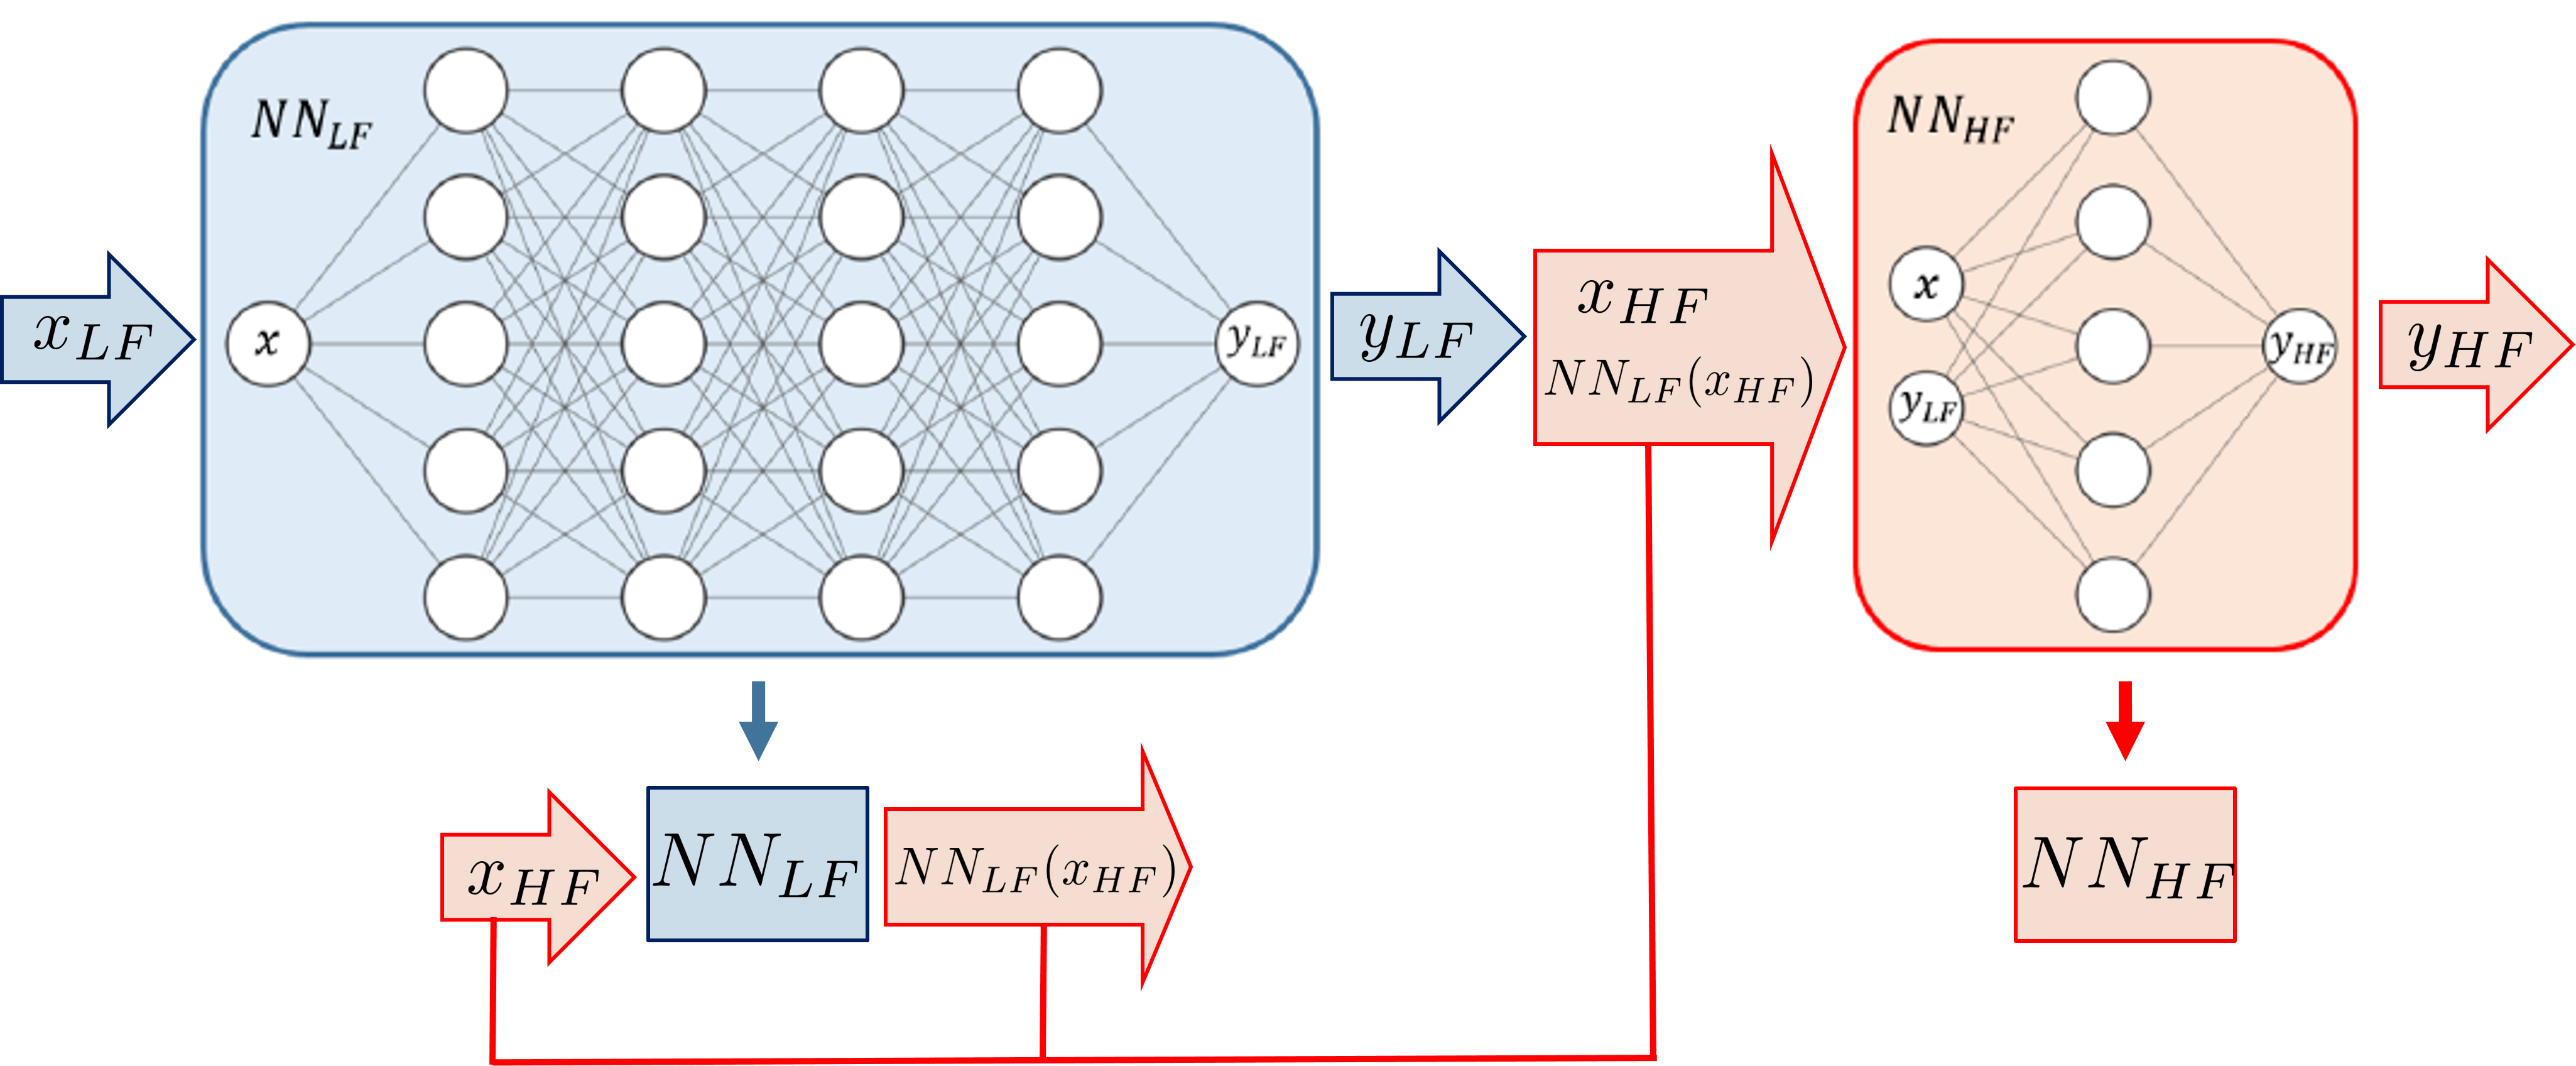

The new network should have:
- 1 hidden Dense layers
- 32 nodes per layer
- activation function = 'tanh'
- kernel_initializer = 'glorot_uniform'
- kernel_regularizer = l2($\lambda$) with $\lambda = 10^{-4}$


In [ ]:
# Evalute the LF model at the HF inputs
xhf_help = #TODO

# Create the inputs by stacking the HF inputs with the corresponding LF predictions
xmf = #TODO

# Do the same for the test data
x_test_help = #TODO
x_test_in =   #TODO

In [ ]:
# Define the MF 2-step model and compile it
inputs = #TODO
x = #TODO
output = Dense(1, activation='linear', name='MF')(x)

modelMF = Model(inputs, output)
optimizer = Adam(learning_rate=0.0255)
modelMF.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


# Train the HF model
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism() # for reproducibility
#TODO:
hist = modelMF.fit(..., ..., epochs=500, batch_size=Nhf, verbose=1)


# Evaluate the HF model on the test set
yMF = #TODO

Plot the exact HF solution, the predicted solution with the MF 2-step, the predicted solution with LF model, the predicted solution with the HF model and the HF training data

In [ ]:
# Plot results
plt.figure()
plt.plot(x_test, Yhf_test, '--k', label='Exact sol.', linewidth = 2)
plt.plot(x_test, yMF, 'r-', label='Predicted MF 2-step')
plt.plot(x_test, yLF, 'b-', label = 'Predicted LF')
plt.plot(x_test, yHF, 'g-', label = 'Predicted HF')
plt.plot(xhf, Yhf, 'ro', label='HF Training Data')

plt.legend()
plt.title('High Fidelity Model - 2-Step')
plt.show()

In [ ]:
# Print percentage errors for LF, HF and MF
print('LF error: ', np.linalg.norm(yLF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('HF error: ', np.linalg.norm(yHF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')
print('MF error: ', np.linalg.norm(yMF - Yhf_test)/np.linalg.norm(Yhf_test)*100, '%')

# **Multi-fidelity reduced-order modeling on Burger's equation**

We aim to create a reduced-order surrogate model that enables the efficient recovery of high-fidelities solutions over time and parameter variations, starting from their low-fidelity counterparts.

We consider a data-driven strategy that combines dimensionality reduction via Proper Orthogonal Decompostion (POD) with multi-fidelity long-short term memory neural (LSTM) network surrogates.


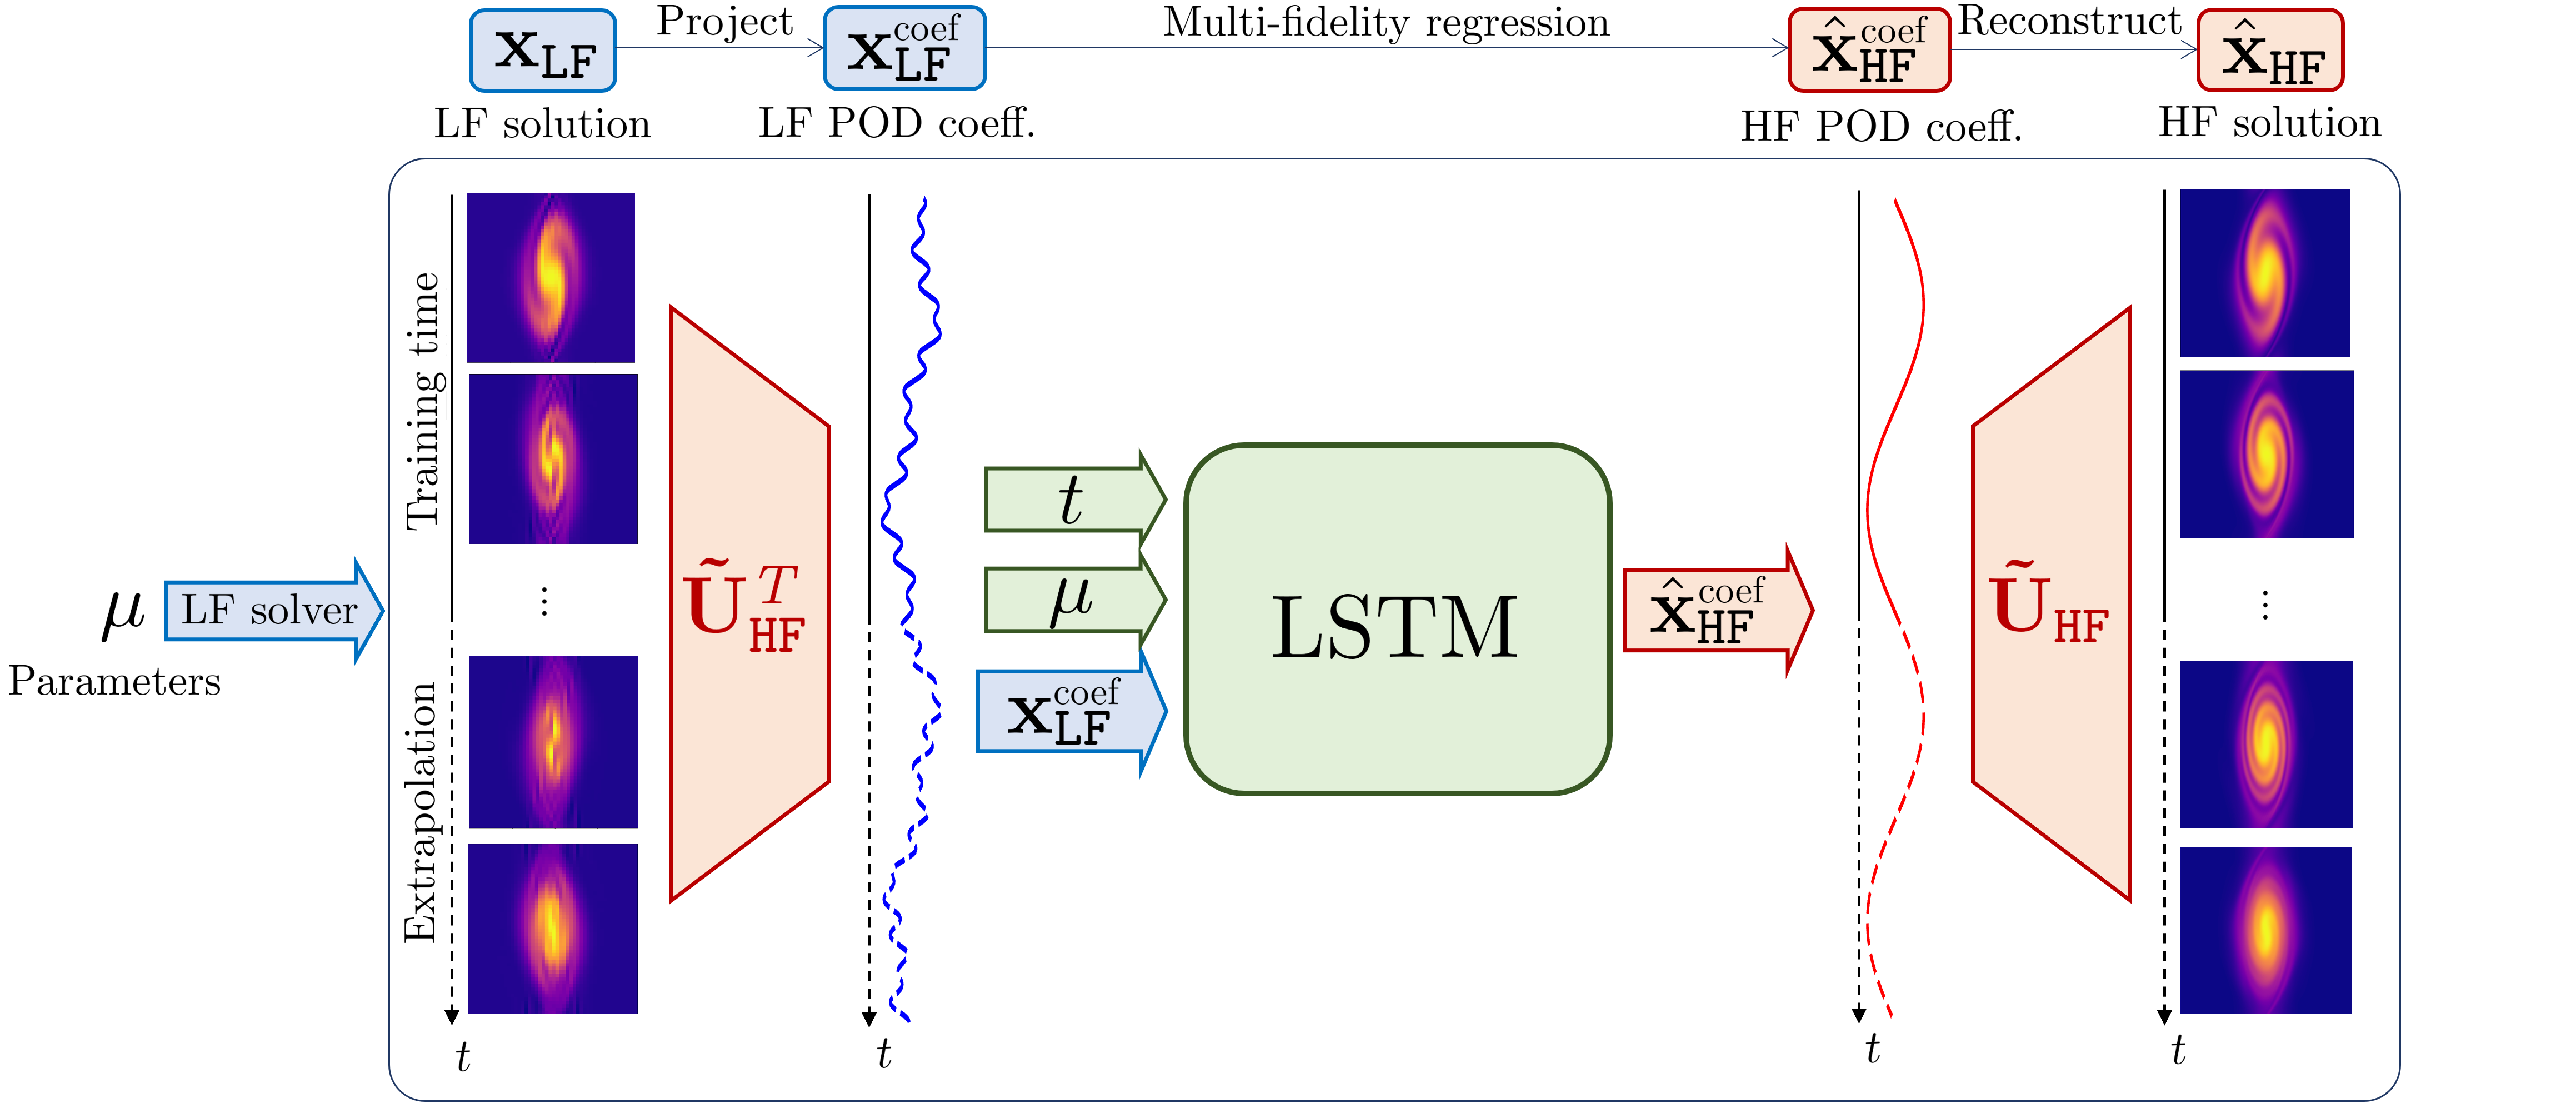

#### In order to do so, we consider the following training strategy

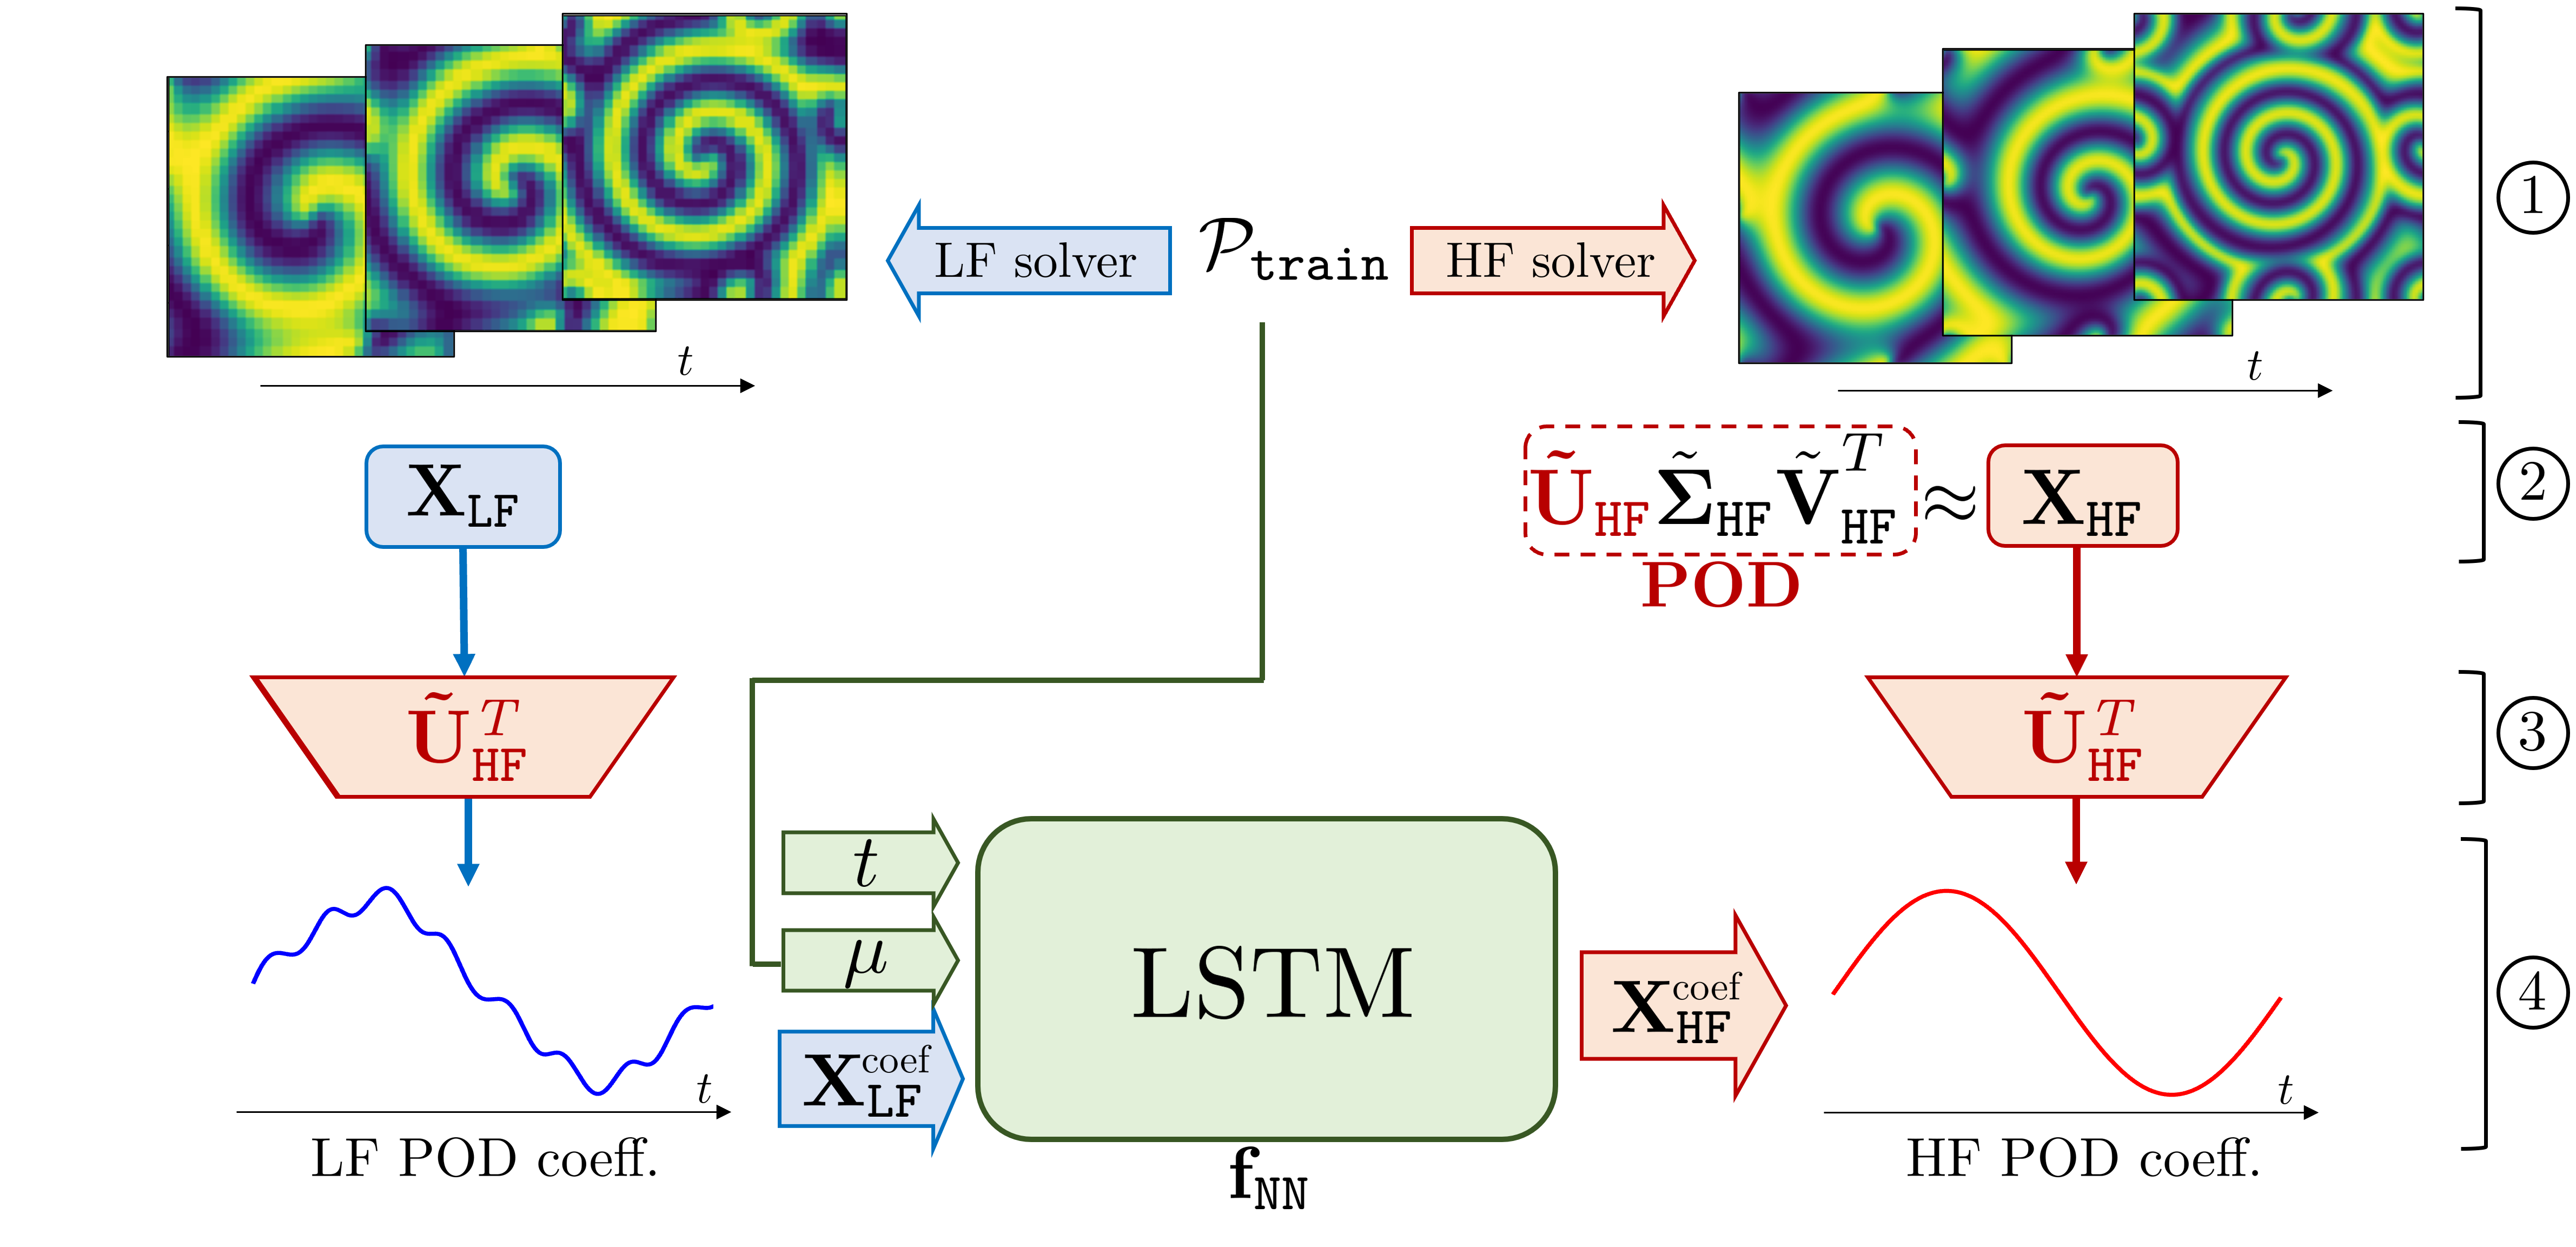

#### (1) **Generation of multi-fidelity dataset**
#### (2) **Dimensionality reduction via POD**
#### (3) **Computing reduced-coordinates via projection**
#### (4) **Training LSTM neural network surrogate model**



#### Problem setup
We consider the following parameter dependent Burger's equation
</br></br>
$$
\begin{equation}
\tag{1}
\frac{\partial u}{\partial t} + \frac{\partial }{\partial x}\left(\frac{1}{2}u^{2}\right) = \frac{1}{Re}\frac{\partial^{2} u}{\partial x^{2}}
\end{equation}
$$
</br>
in $\Omega=(0,1)$, with homogenous Dirichlet boundary conditions and with the following initial condition
</br></br>
$$u(x,0)=\frac{x}{1+e^{-\frac{1}{16}Re\left(1-4x^{2}\right)}},\quad\quad x\in\Omega.$$
</br>
$Re$ denotes the Reynolds parameter and we consider $Re \in [80, 500]$.
</br></br>

### High-fidelity model: exact analytical solution
The high-fidelity function is th eanalytical solution for the problem that is
$$
\begin{equation}
u_\texttt{HF}(x, t; {Re}) = u_{ex}(x, t; {Re}) = \frac{x}{(t+1)\left( 1 + \exp\left(\frac{{Re} \cdot x^2}{4(t+1)}\right) \cdot \sqrt{\frac{t+1}{A_0}}\right)}
\end{equation}
$$
where $A_0 = \exp({Re}/8)$.

---

## Low-fidelity model

The low-fidelity model is a simplified version of the exact solution. It computes the output $u_\texttt{LF}(x, t; {Re}) $ using the following formula:

$$
\begin{equation}
u_\texttt{LF}(x, t; {Re}) = \frac{x}{(t+1)\left( 1 + \exp\left(\frac{{Re} \cdot x}{4(t+1)}\right) \cdot \sqrt{\frac{t+1}{A_0}}\right)}
\end{equation}
$$

This model uses $ x $ (instead of $ x^2 $) in the exponential term, providing a less accurate approximation.

[Credits to Nicola Rares Franco]



In [ ]:
# High-fidelity model: exact analytical solution
def u_HF(x, t, re):
  A0 = np.exp(re/8.0)
  return x/(t+1)/(1.0+np.exp(re*(x**2)/(4*t+4))*((t+1)/A0)**0.5)

# Low-fidelity model
def u_LF(x, t, re):
  A0 = np.exp(re/8.0)
  return x/(t+1)/(1.0+np.exp(re*(x)/(4*t+4))*((t+1)/A0)**0.5)

In [ ]:
# Space-time discretization
nh, nt = 101, 151
T = 2.
L = 1.
x = #TODO # spatial grid
t = #TODO # timepoints

# Uniform sampling of 20 different reynolds numbers
nre = 20
re_min, re_max = 80, 500
np.random.seed(seed)
re = np.random.uniform(re_min, re_max, nre)
re_norm = np.linspace(0, 1, nre) # we sample in [0,1] in order to work with normalized data

#split in train/test with 20% data for testing
re_train, re_test, re_train_norm, re_test_norm = train_test_split(re, re_norm, test_size=0.2, random_state=seed)
nre_train, nre_test = len(re_train), len(re_test)

normalize = lambda r: (r-re_min)/(re_max-re_min) # maps [80, 500] onto [0, 1]
denormalize = lambda r: r*(re_max-re_min) + re_min # maps [0, 1] onto [80, 500]

# Let's see some ground truth simulations
times = [0, nt//2, nt-1]
alphas = [1.0, 0.5, 0.25]
plt.figure(figsize = (7, 5))
for j in range(3):
  plt.subplot(2,2,1)
  plt.plot(x, u_HF(x, t[times[j]], re = 100), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'steelblue')
  plt.title(" High-fidelity $Re$ = 100", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
  plt.subplot(2,2,2)
  plt.plot(x, u_HF(x, t[times[j]], re = 400), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'steelblue')
  plt.title("High-fidelity $Re$ = 400", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
  plt.subplot(2,2,3)
  plt.plot(x, u_LF(x, t[times[j]], re = 100), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'green')
  plt.title("Low-fidelity $Re$ = 400", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
  plt.subplot(2,2,4)
  plt.plot(x, u_LF(x, t[times[j]], re = 400), label = "$t$ = %.2f" % t[times[j]], alpha = alphas[j], color = 'green')
  plt.title("Low-fidelity $Re$ = 400", fontsize = 11)
  plt.xlabel('x')
  plt.legend(loc = 'upper right')
plt.tight_layout()

#### (1) Generation of multi-fidelity dataset

In [ ]:
#Generate training data
u_hf = np.zeros((nre_train, nt, nh))
u_lf = np.zeros((nre_train, nt, nh))

#TODO:
# fill u_hf
# fill_u_lf


#Generate test data
u_hf_test = np.zeros((nre_test, nt, nh))
u_lf_test = np.zeros((nre_test, nt, nh))

#TODO:
# fill uhf_test
# fill u_lf_test


# Plot the data
ind_re = 5
t_grid, x_grid = np.meshgrid(t, x)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(211)
surf = ax.contourf(t_grid, x_grid, u_lf[ind_re].T, cmap='plasma', levels=10)
plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
cbar = fig.colorbar(surf, ax=ax)
cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
plt.title('Low-fidelity $Re = $' + str(int(re_train[ind_re])), fontsize=14)
ax = fig.add_subplot(212)
surf = ax.contourf(t_grid, x_grid, u_hf[ind_re].T, cmap='plasma', levels=10)
plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
cbar = fig.colorbar(surf, ax=ax)
cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
plt.title('High-fidelity $Re = $' + str(int(re_train[ind_re])), fontsize=14)
plt.tight_layout()
plt.show()

#### (2) Dimensionality reduction via POD

In [ ]:
def compute_randomized_SVD(S, N_POD, N_h, n_channels=1):
    U = np.zeros((n_channels * N_h, N_POD))
    for i in range(n_channels):
        U[i * N_h: (i + 1) * N_h], S, V = extmath.randomized_svd(S[i * N_h: (i + 1) * N_h, :],
                                                                      n_components=N_POD, transpose=False,
                                                                      flip_sign=False, random_state=123)
    return U, S, V

In [ ]:
#########################   Proper Orthogonal Decomposition (POD)   ##########################

#Reshape u_hf data from (nre_train, nt, nh) to (nre_train*nt, nh)
u_hf_pod = #TODO

U, S, V = #TODO

n_POD = 16 # we consider the first 16 basis functions

plt.figure(figsize = (5,4))
plt.plot(np.cumsum(S)/np.sum(S),'*-')
plt.axvline(x = n_POD-1, color = 'black', linestyle = '--')
plt.xlabel('# bases')
plt.show()

# Select the first n_POD basis functions
U = U[:,:n_POD]
S = S[:n_POD]

#### (3) Computing reduced-coordinates via projection

In [ ]:
#########################   PROJECTION ONTO POD BASIS    ##########################
u_lf_pod = np.reshape(u_lf, (nre_train*nt, nh))
u_lf_pod_test = np.reshape(u_lf_test, (nre_test*nt, nh))
u_hf_pod_test = np.reshape(u_hf_test, (nre_test*nt, nh))

ulf_train = #TODO
uhf_train = #TODO
ulf_test = #TODO
uhf_test = #TODO

#Reshape back to make data suitable to LSTM network
ulf_train = np.reshape(ulf_train, (nre_train, nt, n_POD))
uhf_train = np.reshape(uhf_train, (nre_train, nt, n_POD))
ulf_test = np.reshape(ulf_test, (nre_test, nt, n_POD))
uhf_test = np.reshape(uhf_test, (nre_test, nt, n_POD))

#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('POD coefficients: LF vs HF', fontsize=14)
for mode in range(6):
    ax = fig.add_subplot(231 + mode)
    plt.plot(t, ulf_train[ind_re,:,mode], label = 'LF', linewidth = 2, color = 'green', linestyle = '--')
    plt.plot(t, uhf_train[ind_re, :, mode], label = 'HF', linewidth = 2, color = 'blue')
    ax.title.set_text('POD coord. ' + str(mode+1))
    plt.xlabel('t')
    plt.legend()
plt.show()

#### (4) Training LSTM neural network surrogate model

In [ ]:
def sliding_windows(data_input, data_output, seq_length, freq=1):
  x = []
  y = []

  for i in range(data_input.shape[0]):
      for j in range(0, data_input.shape[1] - seq_length, freq):
          _x = data_input[i, j:(j + seq_length), :]
          _y = data_output[i, j:(j + seq_length), :]
          x.append(_x)
          y.append(_y)

  return np.array(x), np.array(y)

In [ ]:
# Reshape to make data suitable to LSTM network

# Train
t_grid_lstm, re_grid_lstm = np.meshgrid(t, re_train_norm)
input_train = np.concatenate((t_grid_lstm[:,:,np.newaxis], re_grid_lstm[:,:,np.newaxis], ulf_train), axis = 2)

output_train = uhf_train

# Test
t_grid_lstm_test, re_grid_lstm_test = np.meshgrid(t, re_test_norm)
input_test = np.concatenate((t_grid_lstm_test[:,:,np.newaxis], re_grid_lstm_test[:,:,np.newaxis], ulf_test), axis = 2)

output_test = uhf_test

# Split the data into subsequences
sequence_length = 10
sequence_freq = 2
input_train_seq, output_train_seq = sliding_windows(input_train, output_train, sequence_length, sequence_freq)

In [ ]:
############################   TRAINING    ##############################

## Create the LSTM NN model
#Define input
dim_input = #TODO
inputs =  Input(shape=(None, dim_input))

x = #TODO: Dropout
x = #TODO: LSTM

#Define output
dim_output = #ODO
outputs = Dense(dim_output, activation='linear')(x)

#Define model
model = Model(inputs, outputs)

#Define the optimizer and compile
opti = Adamax(1e-3)
model.compile(loss = 'mse', optimizer = opti)

#Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism() # for reproducibility
hist = model.fit(input_train_seq, output_train_seq, epochs=500, verbose = 1, callbacks=[callback])

### Prediction for new parameters

In [ ]:
#########################   PREDICTION    ##########################

# Predictions on test data
output_pred = model.predict(input_test)

# Plot predicted POD coordinates
ind_test = [0]
for ind_re in ind_test:
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Re = ' + str(int(re_test[ind_re])), fontsize=15)
    for mode in range(6):
      plt.subplot(231 + mode)
      plt.plot(t, output_test[ind_re,:,mode],'b-', label = 'HF', linewidth = 2)
      plt.plot(t, output_pred[ind_re, :, mode], 'r--', label = 'HF pred', linewidth = 2)
      plt.xlabel('t')
      plt.title('POD coord. ' + str(mode+1))
      plt.legend()
    plt.show()

In [ ]:
# Reconstruct solution
u_pred = #TODO

#Compare with HF solution
for ind_re in ind_test:
  fig = plt.figure(figsize=(6, 7.5))
  plt.suptitle('Re = ' + str(int(re_test[ind_re])), fontsize = 14)
  ax = fig.add_subplot(311)
  surf = ax.contourf(t_grid, x_grid, u_lf_test[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Low-fidelity', fontsize=12)
  ax = fig.add_subplot(312)
  surf = ax.contourf(t_grid, x_grid, u_hf_test[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('High-fidelity', fontsize=12)
  ax = fig.add_subplot(313)
  surf = ax.contourf(t_grid, x_grid, u_pred[ind_re].T, cmap='plasma', levels=10)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('u', fontsize=12, labelpad=15, rotation = 0)
  plt.title('MF-POD prediction', fontsize=12)
  plt.tight_layout()
  plt.show()

In [ ]:
#Compute and plot errors
abs_err_lf = np.abs(u_lf_test - u_hf_test)
abs_err_pred = np.abs(u_pred - u_hf_test)

for ind_re in ind_test:
  fig = plt.figure(figsize=(6, 5))
  plt.suptitle('Re = ' + str(int(re_test[ind_re])), fontsize = 14)
  ax = fig.add_subplot(211)
  surf = ax.contourf(t_grid, x_grid, abs_err_lf[ind_re].T, cmap='bwr', levels=10)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('abs. err.', fontsize=12, labelpad=15)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Absolute error for LF', fontsize=12)
  ax = fig.add_subplot(212)
  surf = ax.contourf(t_grid, x_grid, abs_err_pred[ind_re].T, cmap='bwr', levels=10)
  cbar = fig.colorbar(surf, ax=ax)
  cbar.ax.set_ylabel('abs. err.', fontsize=12, labelpad=15)
  plt.xlabel('t', fontsize=12)
  plt.ylabel('x', fontsize=12, labelpad=15, rotation = 0)
  plt.title('Absolute error for MF-POD', fontsize=12)
  plt.tight_layout()
  plt.show()


In [ ]:
rel_err_lf = np.linalg.norm(u_lf_test - u_hf_test)/np.linalg.norm(u_hf_test[ind_re])
rel_err_pred = np.linalg.norm(u_pred - u_hf_test)/np.linalg.norm(u_hf_test[ind_re])

print('Percentage error for LF: ' + str(rel_err_lf*100) + '%')
print('Percentage error for MF-POD: ' + str(rel_err_pred*100) + '%')

### **References**
</br>

[1] Conti, Guo, Manzoni, Frangi, Brunton, Kutz. [Multi-fidelity reduced-order modeling](https://arxiv.org/abs/2309.00325), Proceedings of the Royal Society A (2024).

[2] Guo, Manzoni, Amendt, Conti, Hesthaven.  [Multi-fidelity regression using artificial neural networks: Efficient approximation of parameter-dependent output quantities](https://www.sciencedirect.com/science/article/pii/S0045782521006411?via%3Dihub), Computer methods in applied mechanics and engineering (2022).

[3] Conti, Guo, Manzoni, Hesthaven.  [Multi-fidelity surrogate modeling using long short-term memory networks](https://www.sciencedirect.com/science/article/abs/pii/S0045782522007678?via%3Dihub), Computer methods in applied mechanics and engineering (2023).

### **Extra**
You can find the code for a reaction-diffusion problem at the [Multi-fidelity POD repository](https://github.com/ContiPaolo/MultiFidelity_POD)

For more info, refer to the repositories:
- [MultiFidelity_NNs](https://github.com/ContiPaolo/MultiFidelity_NNs)
- [MultiFidelity_POD](https://github.com/ContiPaolo/MultiFidelity_POD )

⭐ Leave a star to the github repos if you enojyed :)